<a href="https://colab.research.google.com/github/p25-c4/car/blob/main/%ED%9B%84%ED%8C%90%EA%B3%B5%EC%A0%95_kkkk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy import stats
import graphviz
%matplotlib inline
rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False

# 실행결과 경고메시지 출력 제외
import warnings

warnings.filterwarnings('ignore')

In [ ]:

    plate_no : 제품 번호
    rolling_date : 열연작업시각
    spec_long : 제품 규격(해당 규격은 특정 국가의 기준에 맞춰야 한다.)
    spec_country : 제품 규격의 기준이 되는 국가를 나타내는 변수
    steel_kind : 강종(탄소강, 티타늄강) -> 탄소강은 스케일이 잘 생기는 강종이며, 티타늄강은 스케일이 잘 생기지 않는 강종
    pt_thick : 후판 지시 두께
    pt_width : 후판 지시폭
    pt_length : 후판 지시 길이
    hsb : Hot scale Braker(열간 스케일 파쇄기) 적용 여부 -> 열간 스케일 파쇄기는 스케일이 발생하지 않도록 도와주는 장치
    fur_no : 가열로 호기 (가열로 호기마다 같은 제품이지만 미세한 성능의 차이가 보일 수 있음)
    fur_input_row : 가열로 장입열 (가열로에 장입된 열을 나타내는 변수) -> 장입 순서에 가까운 개념
    fur_heat_temp : 가열로의 가열대 소재 온도
    fur_heat_time : 가열로 가열대 재로시간(분)
    fur_soak_temp : 가열로 균열대 소재온도 **
    fur_total_time : 가열로 총 재로시간(분) -> 예열대, 가열대, 균열대의 시간을 합산한 값
    fur_ex_temp : 가열로 추출온도 계산치 (가열로에서 주는 온도와 실제 온도가 다르며, 일정 이상 온도가 갑자기 감소하면 스케일 불량 조건으로 판단될 수 있다.)
    rolling_method : 압연방법 (TMCP, CR) -> 두 방법 모두 스케일을 제거하기 위한 방법 -> TMCP(Temperature-Mechanical Controlled Processing) / CR(Cold Rolling)
    rolling_temp : 압연 온도 (압연 과정 동안 유지되는 주변 온도)
    descaling_count : 압연 디스케일링 횟수 (에어건이나 물을 사용하여 스케일을 제거하는 작업) **
    work_group : 작업조 4조 2교대 (07시/19시 기준)


In [ ]:
df = pd.read_csv("SCALE불량.csv", encoding = "euc-kr")
df

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,PLT_1996,10JAN2023:05:32:25,양품,BV-A,프랑스,C,19,3400,41500,적용,...,1142,55,1151,86,203,1151,CR(제어압연),948,10,4조
996,PLT_1997,10JAN2023:05:39:19,양품,LR-A,영국,C,19,3400,41500,적용,...,1142,55,1151,86,209,1151,CR(제어압연),948,10,4조
997,PLT_1998,10JAN2023:05:52:41,양품,AB/AH32,미국,C,17,3400,43700,적용,...,1169,65,1163,77,227,1163,CR(제어압연),948,10,4조
998,PLT_1999,10JAN2023:06:01:50,양품,NV-A32,영국,C,17,3400,43700,적용,...,1169,65,1163,77,204,1163,CR(제어압연),948,10,4조


In [ ]:
df.drop("plate_no", axis = 1, inplace = True)
df.drop("rolling_date", axis = 1, inplace = True)
df['scale'] = df['scale'].map(lambda x : 0 if x == "양품" else 1)
df

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,0,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,0,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,2열,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,0,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3호기,1열,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,BV-A,프랑스,C,19,3400,41500,적용,1호기,2열,1142,55,1151,86,203,1151,CR(제어압연),948,10,4조
996,0,LR-A,영국,C,19,3400,41500,적용,1호기,2열,1142,55,1151,86,209,1151,CR(제어압연),948,10,4조
997,0,AB/AH32,미국,C,17,3400,43700,적용,2호기,2열,1169,65,1163,77,227,1163,CR(제어압연),948,10,4조
998,0,NV-A32,영국,C,17,3400,43700,적용,2호기,2열,1169,65,1163,77,204,1163,CR(제어압연),948,10,4조


In [ ]:
df.isnull().sum()

scale              0
spec_long          0
spec_country       0
steel_kind         0
pt_thick           0
pt_width           0
pt_length          0
hsb                0
fur_no             0
fur_input_row      0
fur_heat_temp      0
fur_heat_time      0
fur_soak_temp      0
fur_soak_time      0
fur_total_time     0
fur_ex_temp        0
rolling_method     0
rolling_temp       0
descaling_count    0
work_group         0
dtype: int64

In [ ]:
df_numeric = df.select_dtypes(exclude = 'object')
df_numeric.head()

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,descaling_count
0,0,32,3700,15100,1144,116,1133,59,259,1133,934,8
1,0,32,3700,15100,1144,122,1135,53,238,1135,937,8
2,0,33,3600,19200,1129,116,1121,55,258,1121,889,8
3,0,33,3600,19200,1152,125,1127,68,266,1127,885,8
4,0,38,3100,13300,1140,134,1128,48,246,1128,873,8


In [ ]:
df.groupby("fur_no").count()

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
fur_no,,,,,,,,,,,,,,,,,,,
1호기,333,333,333,333,333,333,333,333,333,333,333,333,333,333,333,333,333,333,333
2호기,325,325,325,325,325,325,325,325,325,325,325,325,325,325,325,325,325,325,325
3호기,342,342,342,342,342,342,342,342,342,342,342,342,342,342,342,342,342,342,342


In [ ]:
## 조별 불량률

df_groups = df.groupby(["work_group"])["scale"]
df_w = pd.DataFrame(columns = ["work_group", "PROB"])
for name, g in df_groups:
    df_w = df_w.append({"work_group" : name , "PROB" : g.tolist().count(1)/(g.shape[0])}, ignore_index = True )
df_w



/tmp/ipykernel_8358/1082446255.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_w = df_w.append({"work_group" : name , "PROB" : g.tolist().count(1)/(g.shape[0])}, ignore_index = True )
/tmp/ipykernel_8358/1082446255.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_w = df_w.append({"work_group" : name , "PROB" : g.tolist().count(1)/(g.shape[0])}, ignore_index = True )
/tmp/ipykernel_8358/1082446255.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_w = df_w.append({"work_group" : name , "PROB" : g.tolist().count(1)/(g.shape[0])}, ignore_index = True )
/tmp/ipykernel_8358/1082446255.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

,work_group,PROB
0,1조,0.389286
1,2조,0.291096
2,3조,0.302752
3,4조,0.238095


In [ ]:
df_corr= df.corr().round(3)

/tmp/ipykernel_8358/3098003813.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr= df.corr().round(3)


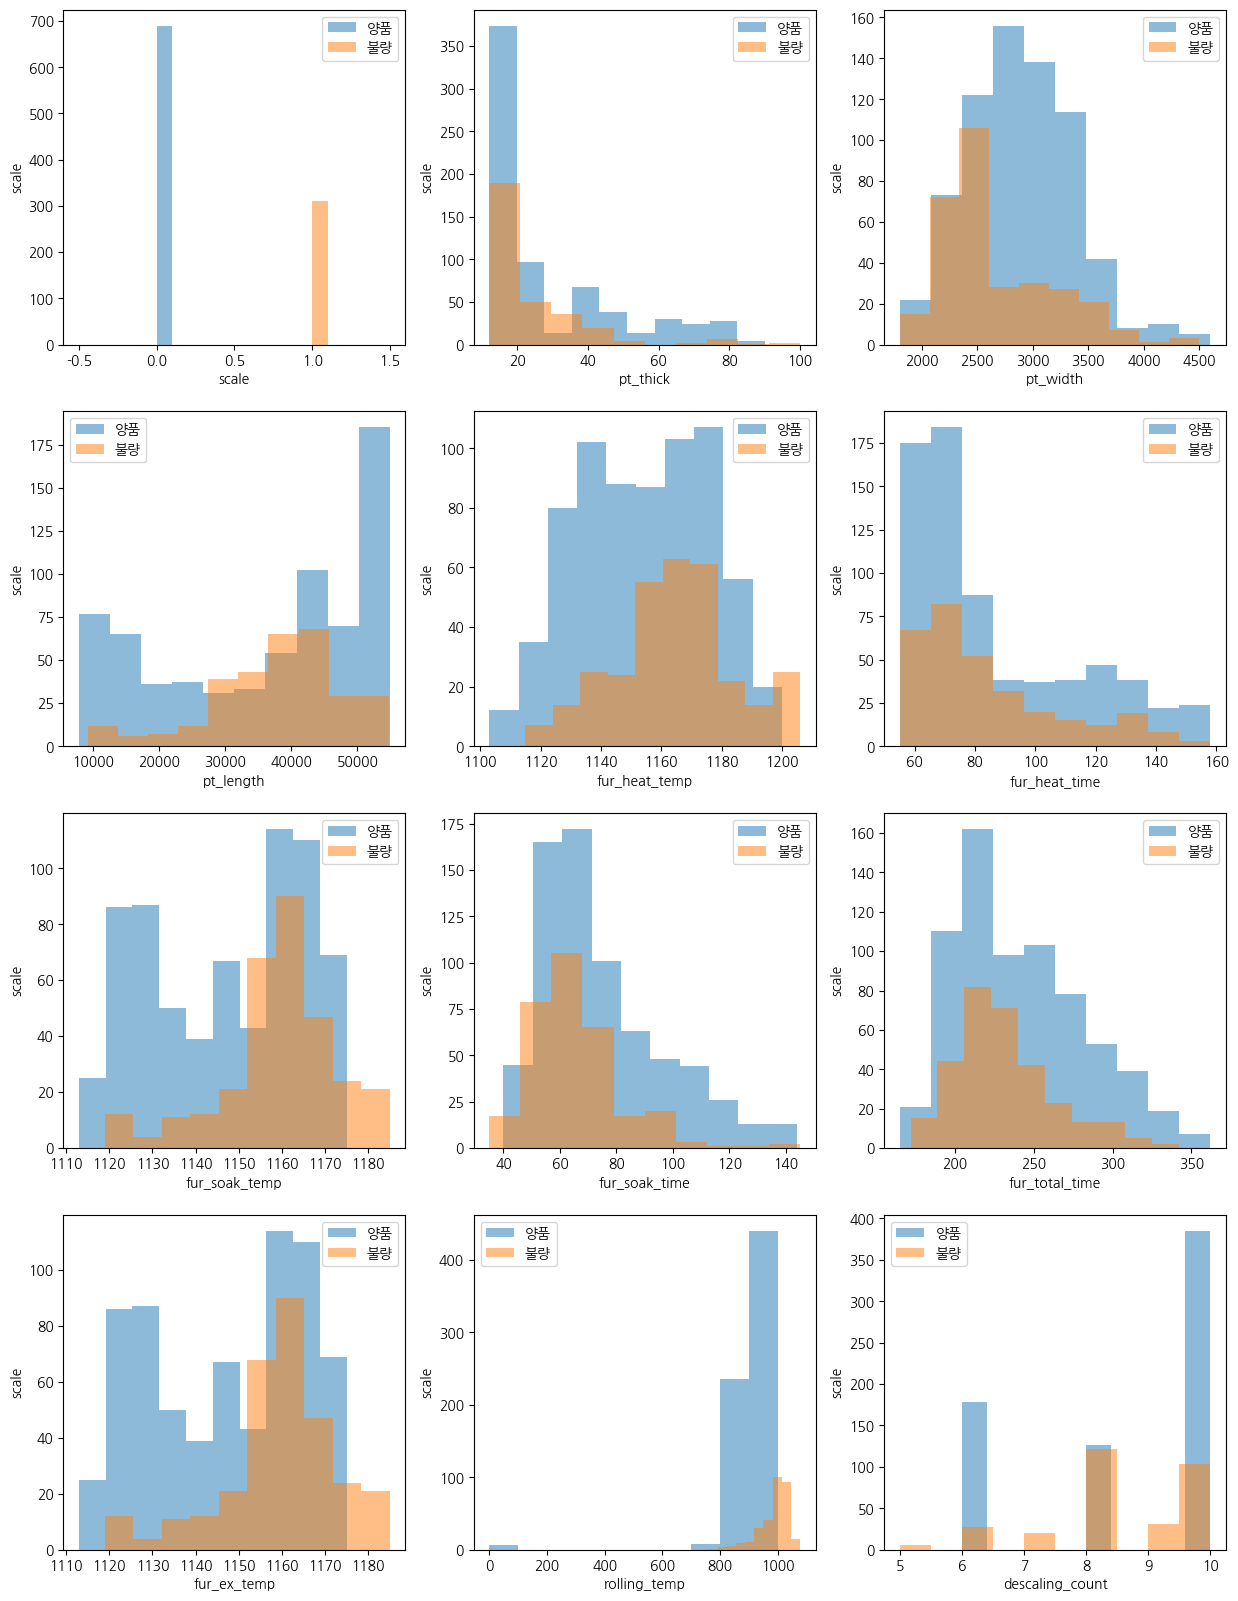

In [ ]:
i = 0
fig = plt.figure(figsize = (15, 20))
columns = df_numeric.columns
for col in df_numeric.columns:
    plt.subplot(df_numeric.shape[1]//3, 3, i+1)
    i += 1
    plt.hist(df[df["scale"] == 0][col], label = "양품", alpha = 0.5)
    plt.hist(df[df["scale"] == 1][col], label = "불량", alpha = 0.5)
    plt.xlabel(col)
    plt.ylabel("scale")
    plt.legend()
plt.show()

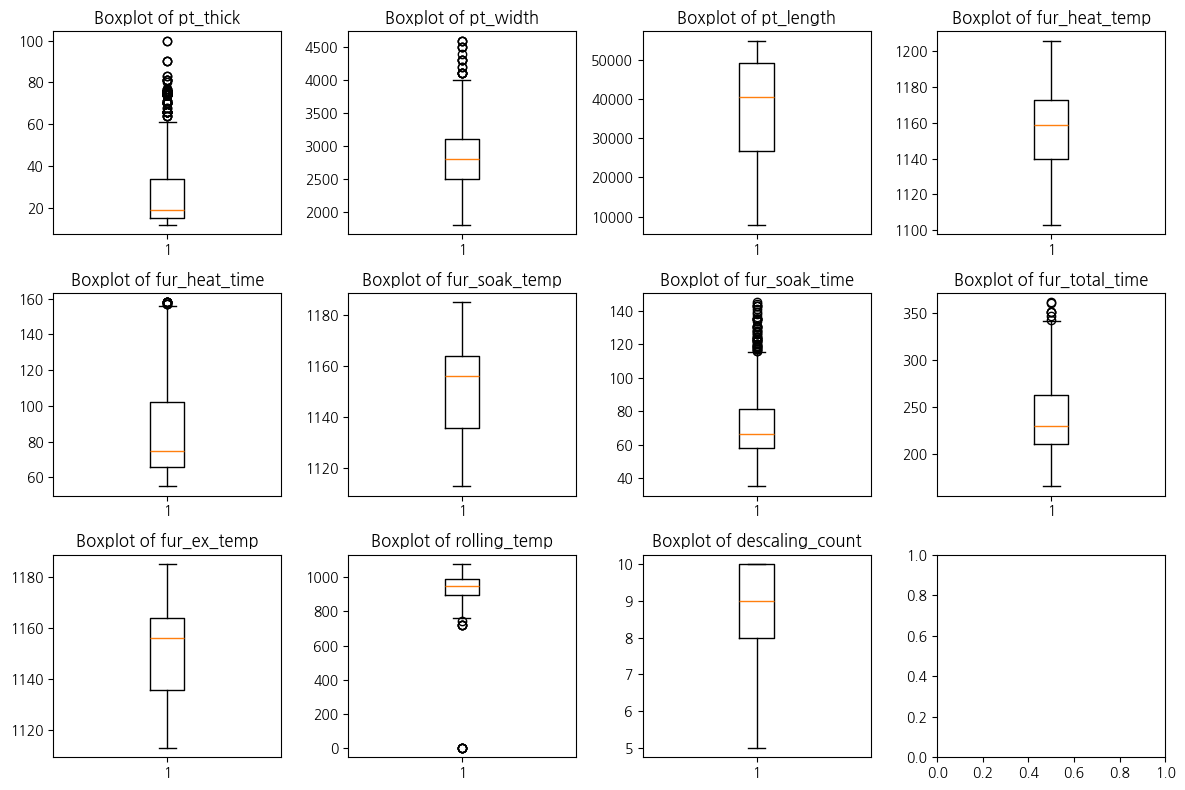

In [ ]:
# 이상치 확인
variables = ['pt_thick', 'pt_width', 'pt_length', 'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp', 'fur_soak_time',
             'fur_total_time', 'fur_ex_temp', 'rolling_temp', 'descaling_count']

# Boxplot
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))  # 3행 4열의 subplot 생성
axes = axes.flatten()

for i, variable in enumerate(variables):
    axes[i].boxplot(df[variable])
    axes[i].set_title(f"Boxplot of {variable}")

# subplot 간 간격 조정
plt.tight_layout()

# 그래프 출력
plt.show()

<Axes: >

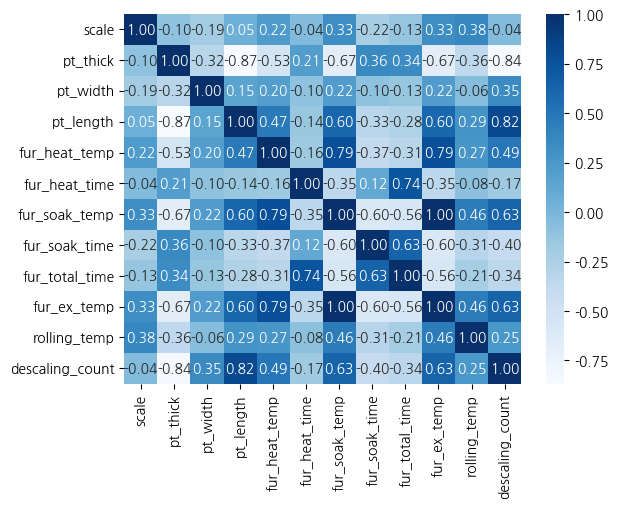

In [ ]:
sns.heatmap(df_corr, annot = True, fmt = ".2f", cmap= "Blues")

<Axes: xlabel='fur_heat_temp', ylabel='fur_soak_temp'>

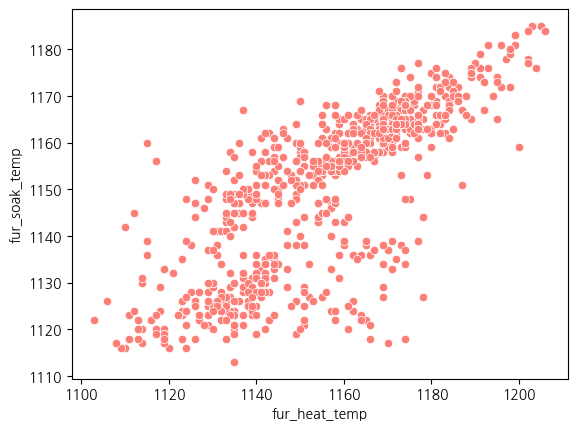

In [ ]:
sns.scatterplot(data=df, x="fur_heat_temp", y="fur_soak_temp",color = "#FC7F77")




<Axes: xlabel='fur_heat_temp', ylabel='rolling_temp'>

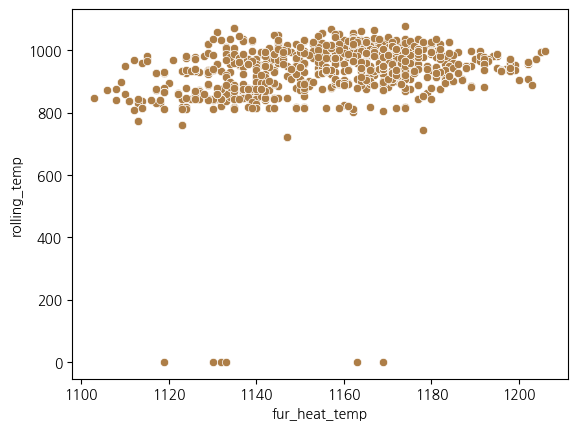

In [ ]:
sns.scatterplot(data=df, x="fur_heat_temp", y="rolling_temp",color = "#AD7E47")

<Axes: xlabel='fur_heat_temp', ylabel='fur_ex_temp'>

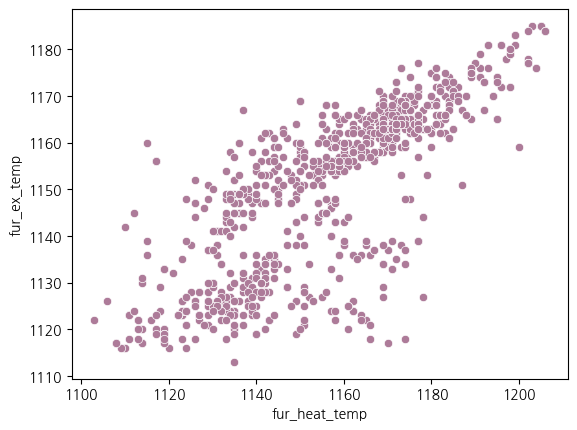

In [ ]:
sns.scatterplot(data=df, x="fur_heat_temp", y="fur_ex_temp",color = "#AD7B99")

<Axes: xlabel='fur_soak_temp', ylabel='rolling_temp'>

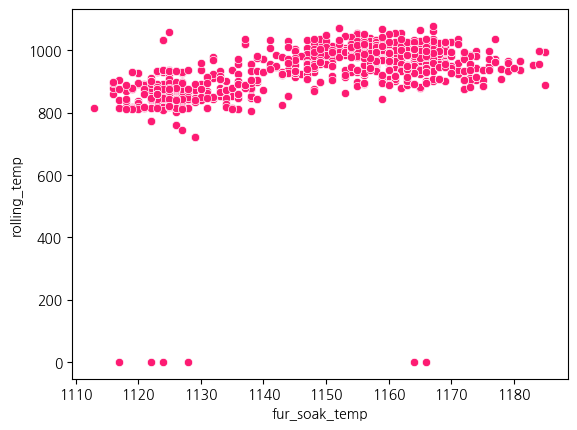

In [ ]:
sns.scatterplot(data=df, x="fur_soak_temp", y="rolling_temp",color = "#FD1B73")

<Axes: xlabel='fur_soak_temp', ylabel='fur_ex_temp'>

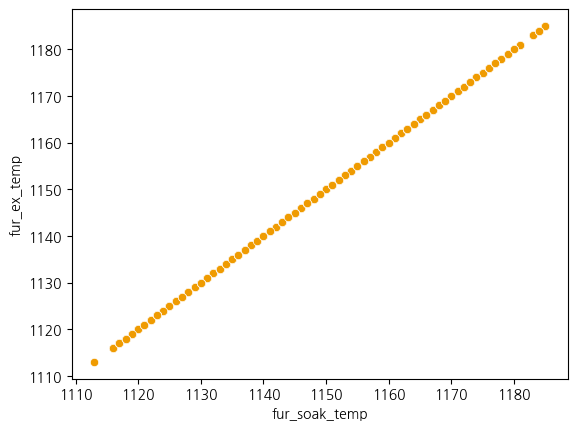

In [ ]:
sns.scatterplot(data=df, x="fur_soak_temp", y="fur_ex_temp",color = "#EF9B01")

<Axes: xlabel='rolling_temp', ylabel='fur_ex_temp'>

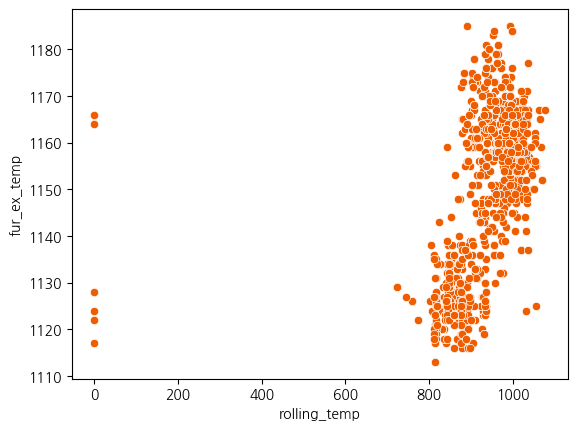

In [ ]:
sns.scatterplot(data=df, x="rolling_temp", y="fur_ex_temp",color = "#EF5D01")

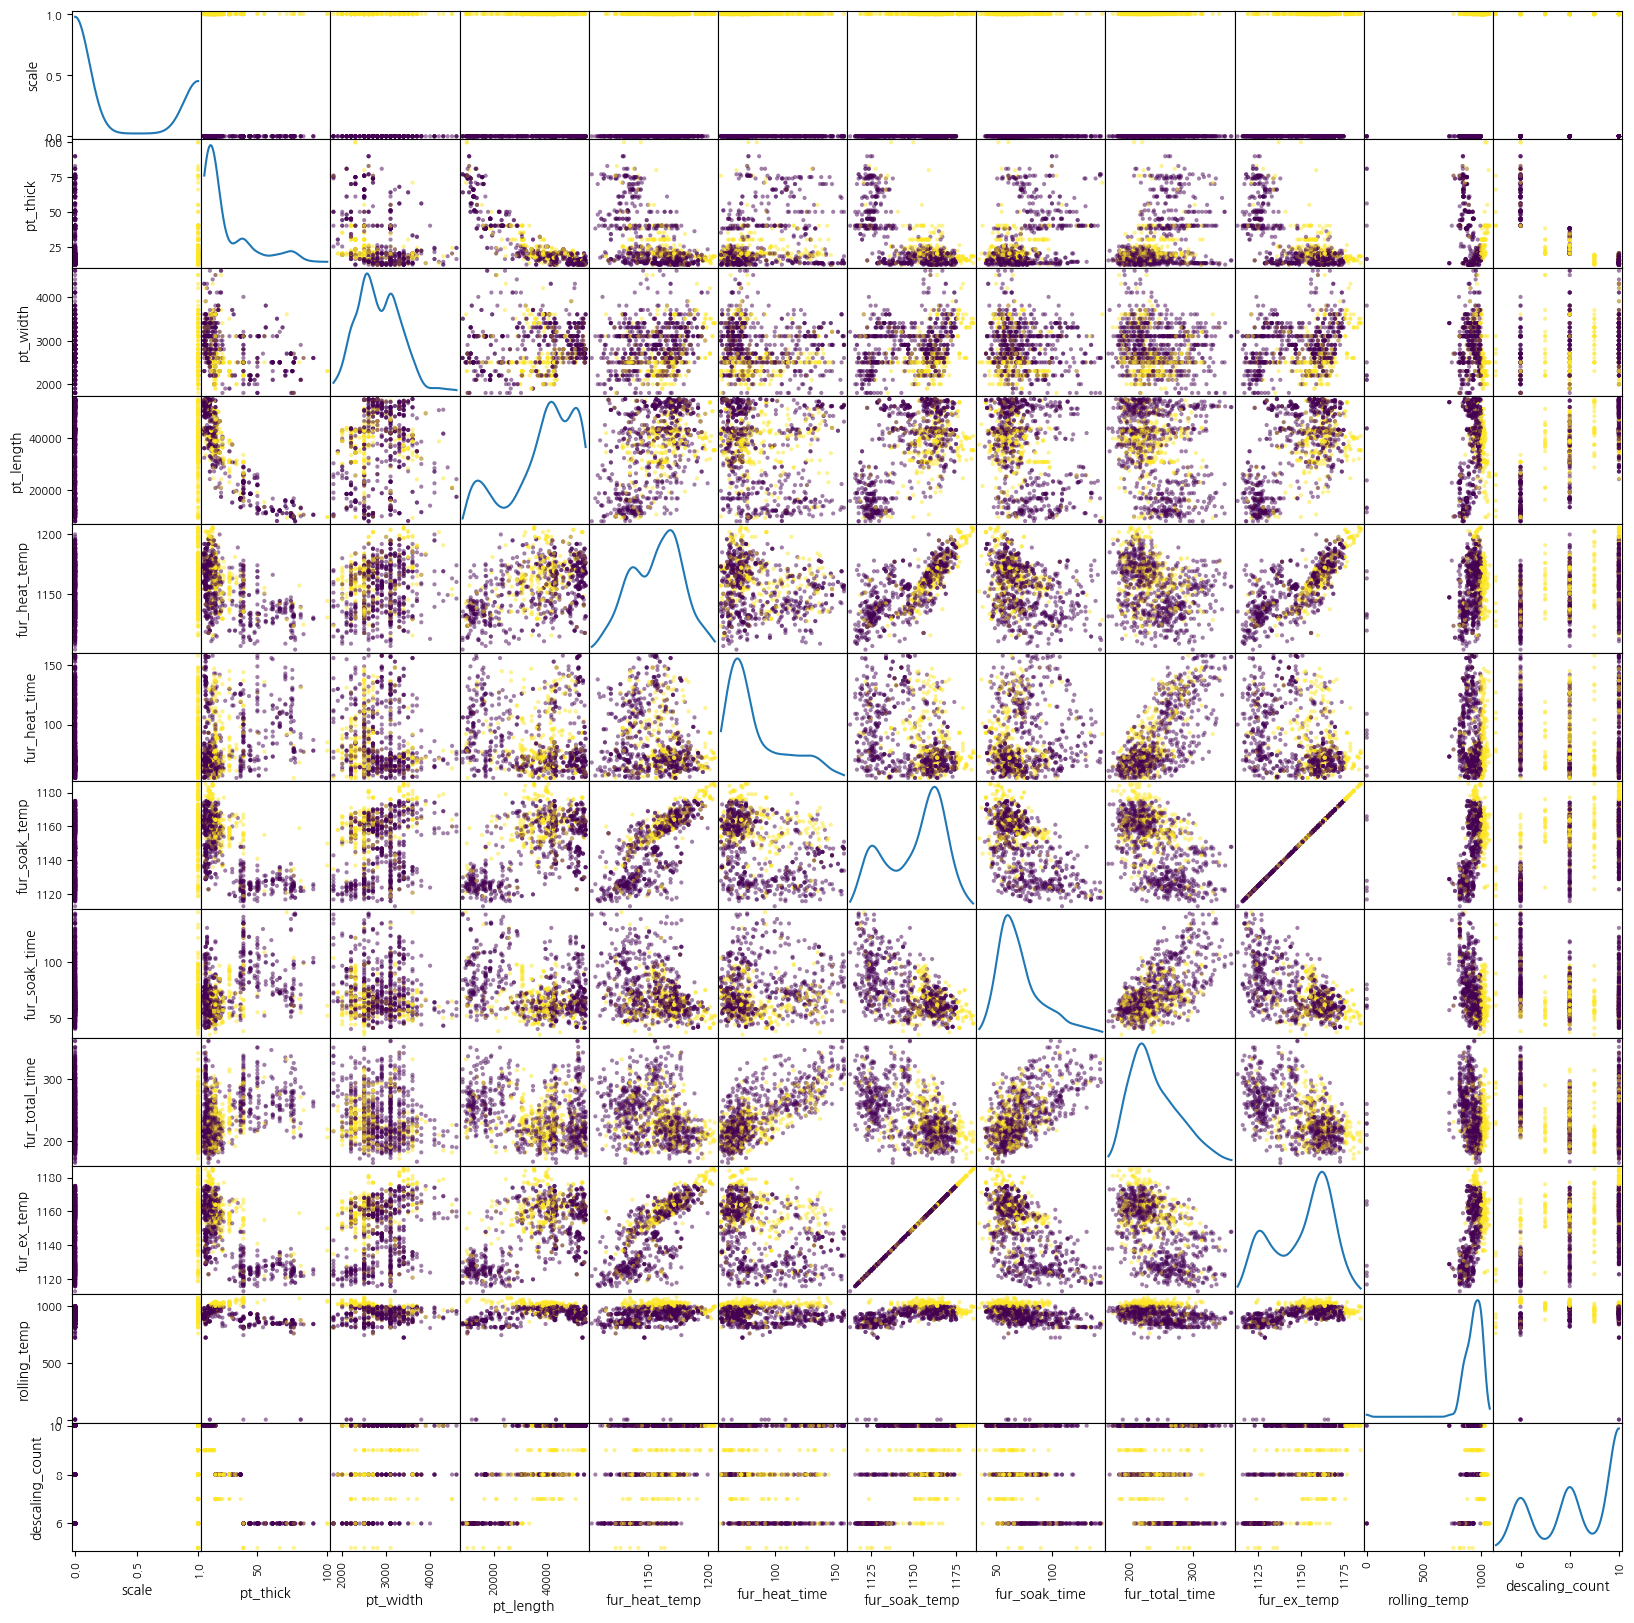

In [ ]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# iris data 를, target 별 다른 색으로 표현
scatter_matrix(df,
               c = df['scale'],
               alpha=0.5,
               figsize=(20, 20),
               diagonal='kde')
plt.show()

In [ ]:
df['steel_kind'][]

0      T
1      T
2      T
3      T
4      T
      ..
995    C
996    C
997    C
998    C
999    C
Name: steel_kind, Length: 1000, dtype: object

<Axes: xlabel='descaling_count', ylabel='count'>

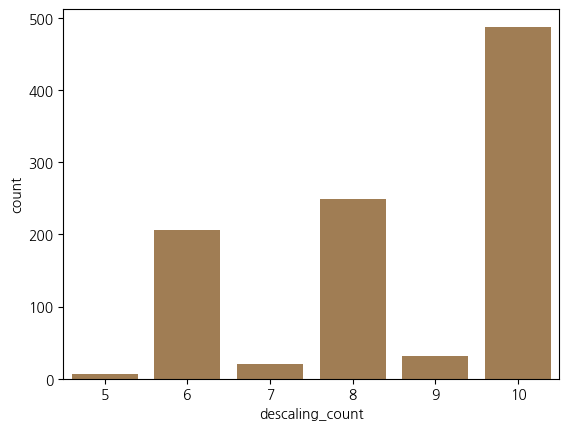

In [ ]:
sns.countplot(data=df,x="descaling_count",color = "#AD7E47")